# Kaggle-Cassava-Leaf-Disease-Classification
__Main Goal__

+ Classifying each image in one of the five possible classes
+ Source: https://www.kaggle.com/c/cassava-leaf-disease-classification
+ This notebook is for the inference phase

In [1]:
#Loading libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from pathlib import Path
import math

In [2]:
#Loading fastai modules
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.callback.fp16 import *
from fastai.vision import *
import fastai
import torch
from fastai.callback.all import SaveModelCallback
from sklearn.metrics import confusion_matrix, classification_report, recall_score, roc_auc_score, cohen_kappa_score
import seaborn as sns

In [3]:
#Showing and saving the graphs within this notebook
%matplotlib inline
#Reload automatically the modules after executing each cell
%reload_ext autoreload
%autoreload 2

In [4]:
#Path to your csv and images folders
path = Path('../input/cassava-leaf-disease-classification')

In [5]:
classes=pd.read_json('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json', typ='series')

# Functions

In [6]:
def get_x(r): return path/'train_images'/r['image_id']
def get_y(r): return r['label']

In [7]:
def gen_data(size, pre_size,bs=64,metodo='method1'):
    if(metodo=='method1'):
        datablock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                    splitter=RandomSplitter(seed=42),
                    item_tfms=Resize(pre_size),
                    get_x=get_x, 
                    get_y=get_y,
                    batch_tfms=aug_transforms(size=size, min_scale=0.95))
    elif(metodo=='method2'):
         datablock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                    splitter=RandomSplitter(seed=42),
                    item_tfms=Resize(pre_size),
                    get_x=get_x, 
                    get_y=get_y,
                    batch_tfms=aug_transforms())

    return datablock.dataloaders(data,batch_size=bs)

def create_learn(dls, multi_gpu=True, mixup=False, label_smooth_eps=0.1, model=resnet50,metrics=accuracy):
    if mixup==False:
        learn = cnn_learner(dls, model, metrics=metrics, 
                        loss_func=LabelSmoothingCrossEntropy(eps=label_smooth_eps))
    else:
        learn = cnn_learner(dls, model, metrics=metrics, 
                        loss_func=LabelSmoothingCrossEntropy(eps=label_smooth_eps),
                        cbs=MixUp)
        print('mixup enabled')
    if multi_gpu:
        learn.model = nn.DataParallel(learn.model) 
        print('multi-gpu enabled')
    learn.path = path
    learn = learn.to_fp16()
    return learn

def report_metrics(learn, preds):
    y_true = preds[1].tolist()
    y_probs = preds[0].numpy()
    auc = roc_auc_score(y_true, y_probs, multi_class='ovo') # ovo because macro avg is used (ovo is insensitive to class imbalance)
    print(f'AUC: {auc}')
    y_pred = y_probs.argmax(axis=1)
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=list(learn.dls.vocab)))

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [10]:
def print_confusion_matrix(y_true,y_preds):
    cf_matrix = confusion_matrix(y_true, y_preds)
    fig, ax = plt.subplots(figsize=(8,8)) 
    x_axis_labels = [clases[0],clases[1],clases[2],clases[3],clases[4]]
    y_axis_labels  = [clases[0],clases[1],clases[2],clases[3],clases[4]]
    sns.heatmap(cf_matrix, linewidths=2, linecolor = 'white', annot=True, ax=ax, fmt='g', xticklabels = x_axis_labels,yticklabels = y_axis_labels, cmap = 'Purples')
    plt.xlabel("\nPredicted", size = 16)
    plt.ylabel("Truth\n", size = 16)
    plt.show()

In [12]:
def report_metrics(y_true, y_preds):
    print(classification_report(y_true, y_preds, target_names=x_axis_labels))

# Inference

+ **We load the best model trained on the Cassava-Training-GitHub Notebook**

In [8]:
filename = '../input/model2/finalized_model2.sav'

In [9]:
learn = pickle.load(open(filename, 'rb'))

In [11]:
x_axis_labels = [classes[0],classes[1],classes[2],classes[3],classes[4]]

In [ ]:
#Submission example
sample_df = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')
sample_df.head()

In [31]:
sample_copy = sample_df.copy()

In [32]:
path=Path('../')

In [33]:
#We create a dataframe with all the test images and we add it to the dataloader
sample_copy['image_id'] = sample_copy['image_id'].apply(lambda x: path/'input/cassava-leaf-disease-classification/test_images'/x)

In [34]:
test_dl = learn.dls.test_dl(sample_copy)

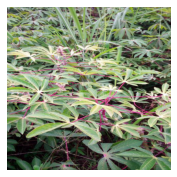

In [35]:
test_dl.show_batch()

+ **We use Test Time Augmentation (tta) for each prediction in order to improve the performance**

In [36]:
preds, _ = learn.tta(dl=test_dl)

In [37]:
sample_df['label'] = preds.argmax(dim=-1).numpy()

In [38]:
#We export the dataframe to a csv that will be the submission to the kaggle platform
sample_df.to_csv('submission.csv',index=False)